In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import random as python_random
from keras.initializers import GlorotUniform
from keras.initializers import Orthogonal

np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

In [ ]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [ ]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [ ]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [ ]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('./output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle = False)

    return X_train, X_test, y_train, y_test

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
def build_model(input_shape, md_prm: dict):

    model = Sequential()
    initializer = GlorotUniform(seed=42)

    model.add(LSTM(md_prm['lstm_units1'], return_sequences=True, input_shape=input_shape, kernel_initializer=initializer))
    model.add(LSTM(md_prm['lstm_units2'], kernel_initializer=initializer))
    model.add(Dense(1, kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error', metrics=[rmse])
    return model

In [ ]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):

    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =75,
        verbose             =1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs              =epochs,
        batch_size          =batch_size,
        verbose             =verbose,
        callbacks           =[early_stopping],
        validation_split    =0.05
    )

    return history

In [ ]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [ ]:
def plot_predictions(y_true, y_pred, n=-1, title="Prediction vs Actual Data", markersize=3, rmse=None):
    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 2.5))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)

    # Plot the RMSE lines if rmse is provided
    if rmse is not None:
        plt.axhline(y= rmse, color='green', linestyle='--', linewidth=0.7)
        plt.axhline(y=-rmse, color='green', linestyle='--', linewidth=0.7)

        tot_pred = 0
        prof = 0
        loss = 0

        # plot green markers beyond the rmse range
        for i in range(len(y_pred)):
            if (y_pred[i] > rmse or y_pred[i] < - rmse):
                # print("{} {}".format(y_pred[i],y_true[i]))
                if (y_true[i] > 0 and y_pred[i] > 0) or (y_true[i] < 0 and y_pred[i] < 0):
                    plt.plot(i, y_pred[i], 'gx', markersize=markersize+1)
                    prof += 1
                else:
                    plt.plot(i, y_pred[i], 'rx', markersize=markersize+1)
                    loss += 1
                tot_pred += 1
            else:
                plt.plot(i, y_pred[i], marker='x', color='orange', markersize=markersize-1)

    else:
        plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
        plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return tot_pred, prof, loss

In [ ]:
def trend_accuracy(y_true, y_pred):
    trend_up_true = 0
    trend_down_true = 0
    trend_up_pred = 0
    trend_down_pred = 0

    for j in range(len(y_true)-1):
        if y_true[j] > 0.0:
            trend_up_pred += 1
            if y_pred[j] > 0.0:
                trend_up_true += 1
        if y_true[j] < 0.0:
            trend_down_pred += 1
            if y_pred[j] < 0.0:
                trend_down_true += 1

    trend_true = trend_up_true + trend_down_true
    trend_pred = trend_up_pred + trend_down_pred

    trend_up_accuracy = trend_up_true/trend_up_pred
    trend_down_accuracy = trend_down_true/trend_down_pred
    trend_accuracy = trend_true/trend_pred

    return trend_accuracy, trend_up_accuracy, trend_down_accuracy

In [ ]:
n_steps_options     = [40 ,60,120]
batch_size_options  = [256,128,64]
epochs_options      = [300]

lstm_units_options1 = [25,75]
lstm_units_options2 = [25,75]
activation_options  = ['relu']
dropout_options     = [.15]
num_layers_options  = [2]

# # caso seleccionado
# n_steps_options     = [120]
# batch_size_options  = [256]
# epochs_options      = [300]

# lstm_units_options  = [25]
# activation_options  = ['relu']
# dropout_options     = [.15]
# num_layers_options  = [2]

# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
# print(modified_lists)
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAG','XAU','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# combinations
model_params_combinations = list(itertools.product(
    n_steps_options     ,
    lstm_units_options1,
    lstm_units_options2,
    activation_options,
    dropout_options,
    num_layers_options,
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

In [ ]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 36


In [ ]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units1, lstm_units2, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:

            # data load
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units1: {}, lstm_units2: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units1, lstm_units2, activation, dropout, num_layers)
            )

            print("Train : batch> {}".format(batch_size))

            # data preparation
            # print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)

            # build model
            model_params = {
                'lstm_units1': lstm_units1,
                'lstm_units2': lstm_units2,
                'activation': activation,
                'dropout'   : dropout,
                'num_layers': num_layers
            }
            input_shape = (X_train.shape[1], X_train.shape[2])
            print("Input shape: {}".format(input_shape))
            model = build_model(input_shape, model_params)
            print(model.summary())

            # model train
            if True:
                history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                # model evaluation
                y_pred      = model.predict(X_test)
                rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
                std_dev     = np.std(y_test)

                print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

                if rmse_score < std_dev:
                    diff = rmse_score - std_dev + abs(np.std(y_pred) - std_dev)/4.0
                else:
                    diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0

                # diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0
                tren_acc, trend_up, trend_down = trend_accuracy(y_test, y_pred)
                result = {
                    'n_steps'   : n_steps,
                    'lstm_units1': lstm_units1,
                    'lstm_units2': lstm_units2,
                    'activation': activation,
                    'dropout'   : dropout,
                    'num_layers': num_layers,
                    'batch_size': batch_size,
                    'epochs'    : epochs,
                    'rmse'      : rmse_score,
                    'std_dev'   : std_dev,
                    'diff'      : diff,
                    'predictions': y_pred,
                    'true_values': y_test,
                    'feature_list': var_options,
                    'tr_ac': tren_acc,
                    'tr_up': trend_up,
                    'tr_down': trend_down
                }

                # print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
                print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(rmse_score, std_dev, np.std(y_pred), diff, (rmse_score - std_dev)))

                print("Trend: {:.2f}, Up: {:.2f}, Down: {:.2f}".format(tren_acc*100, trend_up*100, trend_down*100))

                top_results.append(result)
                top_results = sorted(top_results, key=lambda x: x['diff'])
                plot_predictions(result['true_values'], result['predictions'], -1, title="It. {}".format(i),rmse = rmse_score)

            print("Completed Iteration {}/{}".format(i, n_iterations))
        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1
    return top_results


Iteration 1/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 25)            3600      
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________

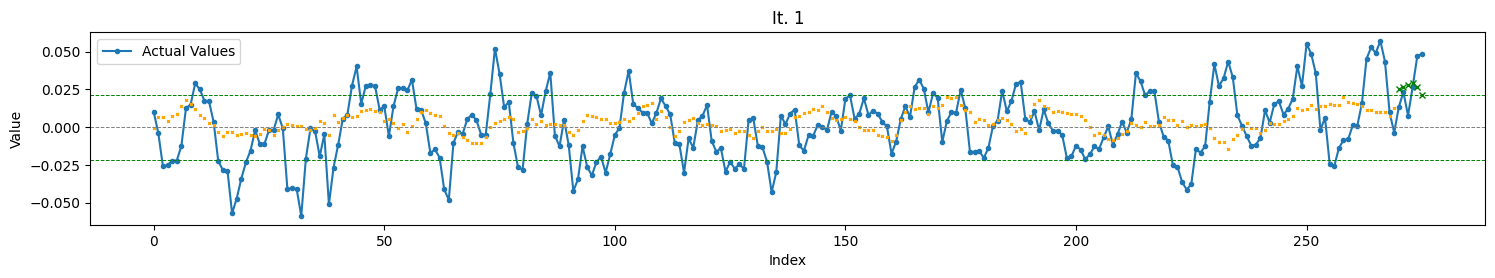

Completed Iteration 1/36

Iteration 2/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

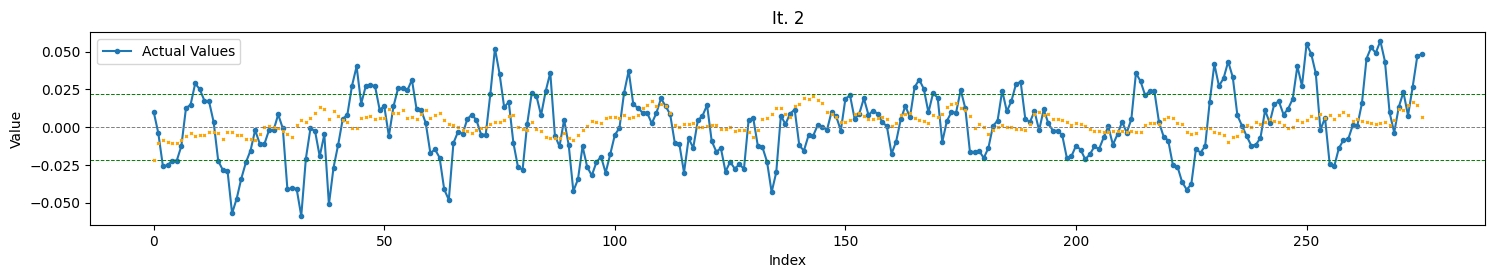

Completed Iteration 2/36

Iteration 3/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

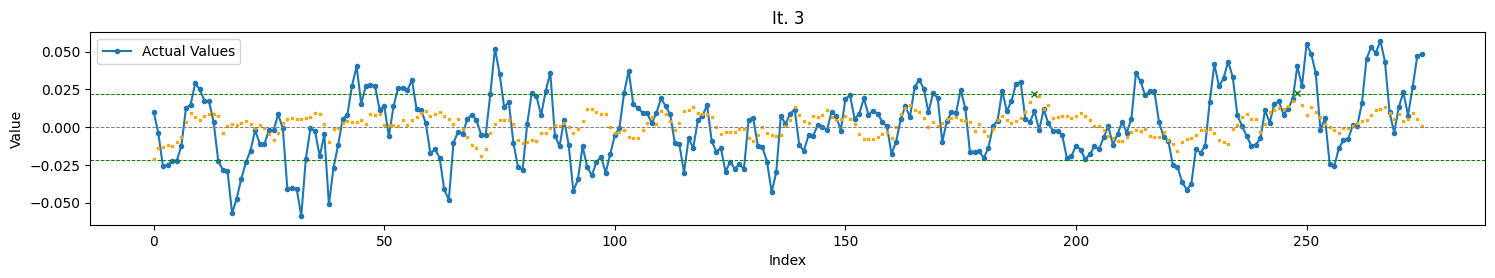

Completed Iteration 3/36

Iteration 4/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_7 (LSTM)               (None, 75)                30300     
                                                                 
 dense_3 (Dense)             (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

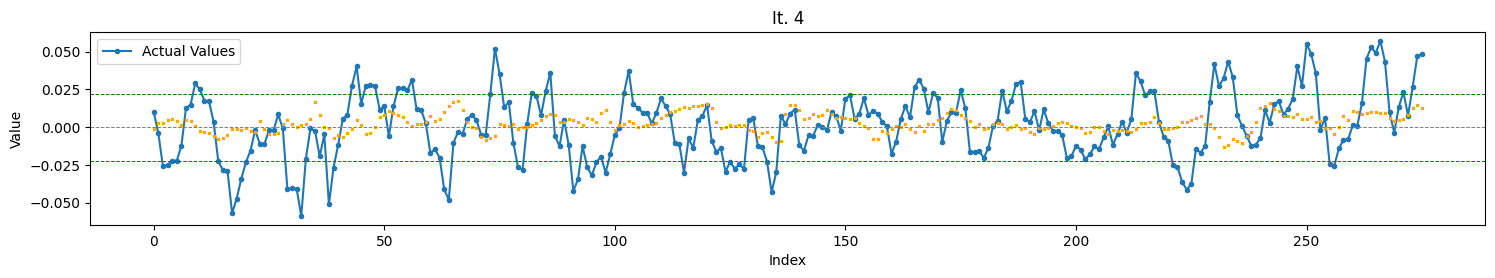

Completed Iteration 4/36

Iteration 5/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 25)            3600      
                                                                 
 lstm_9 (LSTM)               (None, 75)                30300     
                                                                 
 dense_4 (Dense)             (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

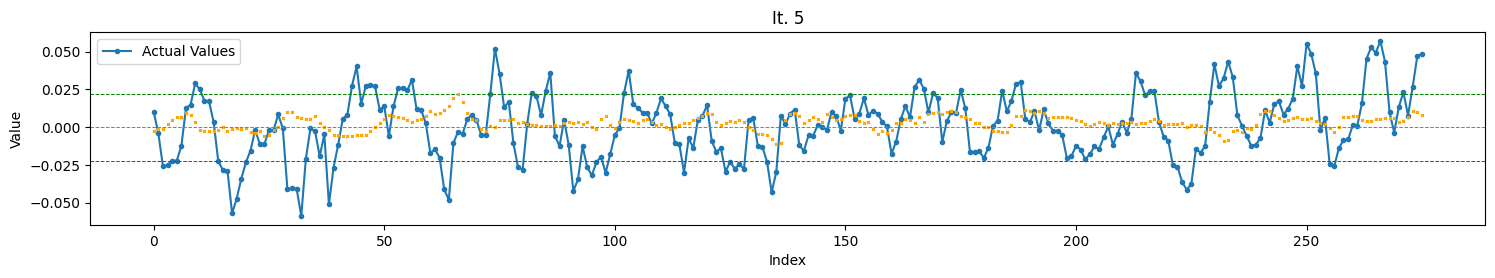

Completed Iteration 5/36

Iteration 6/36
Params: n_steps: 40, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 40, 25)            3600      
                                                                 
 lstm_11 (LSTM)              (None, 75)                30300     
                                                                 
 dense_5 (Dense)             (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
______________

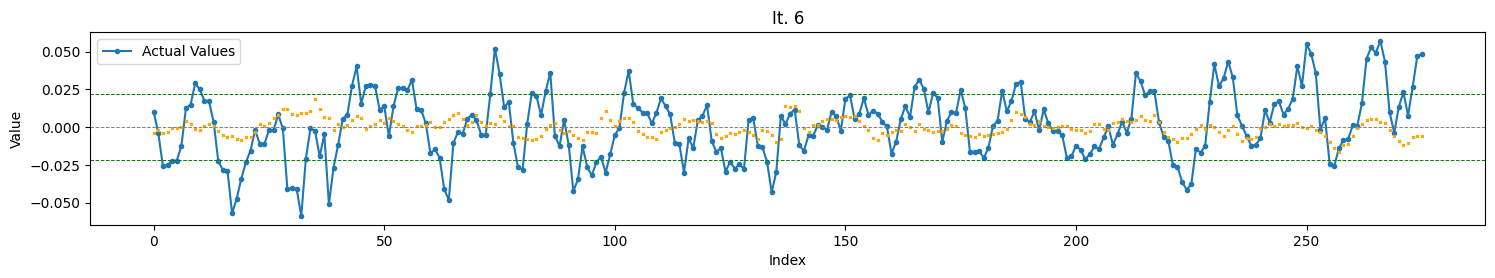

Completed Iteration 6/36

Iteration 7/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_13 (LSTM)              (None, 25)                10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

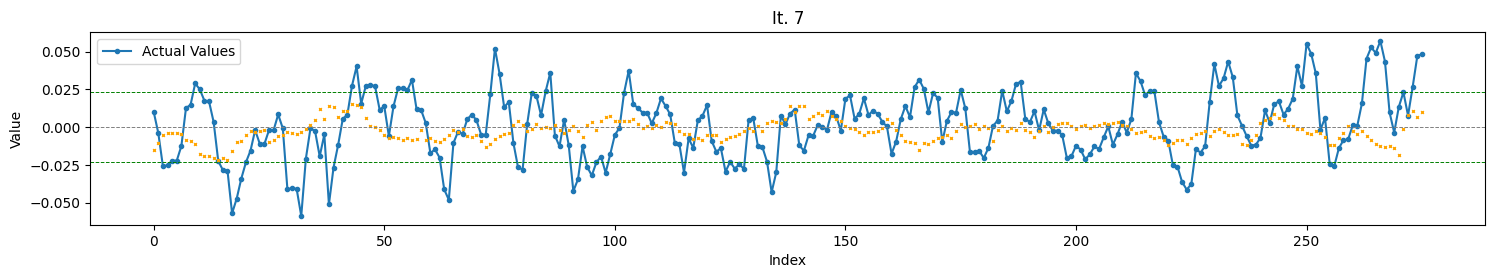

Completed Iteration 7/36

Iteration 8/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_15 (LSTM)              (None, 25)                10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

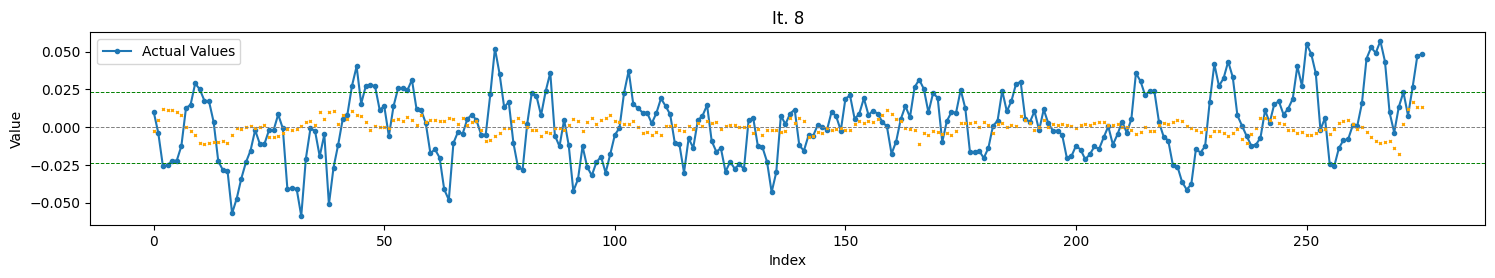

Completed Iteration 8/36

Iteration 9/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_17 (LSTM)              (None, 25)                10100     
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
______________

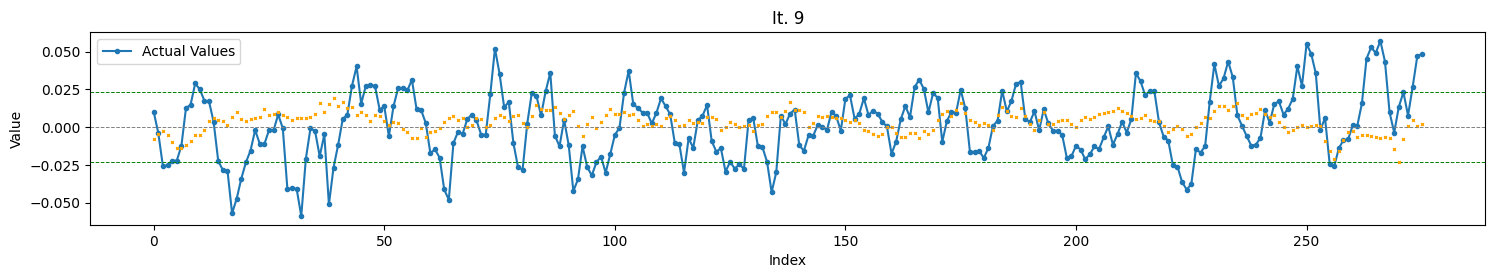

Completed Iteration 9/36

Iteration 10/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_19 (LSTM)              (None, 75)                45300     
                                                                 
 dense_9 (Dense)             (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
____________

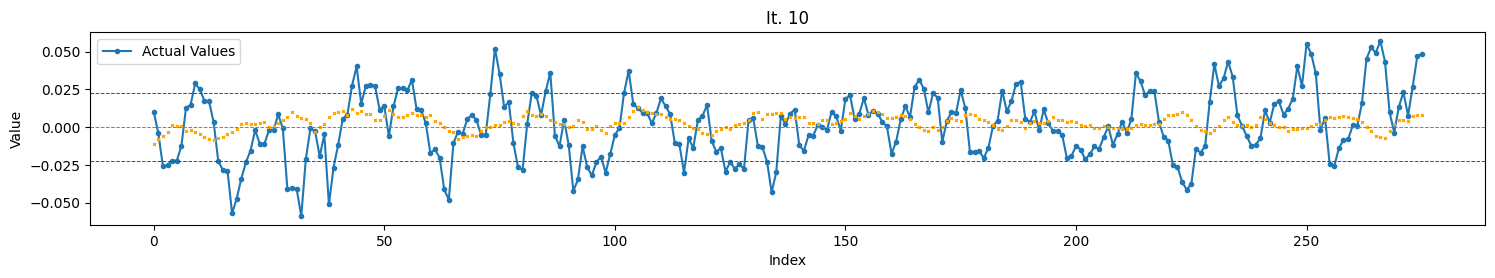

Completed Iteration 10/36

Iteration 11/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_21 (LSTM)              (None, 75)                45300     
                                                                 
 dense_10 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
__________

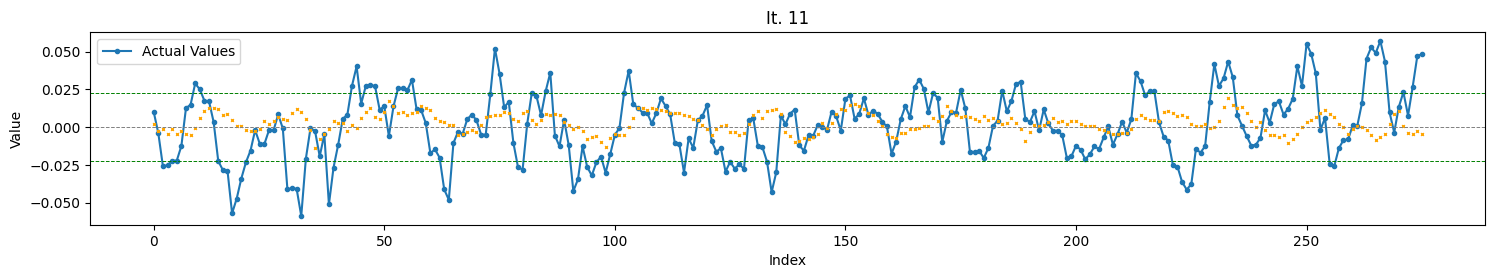

Completed Iteration 11/36

Iteration 12/36
Params: n_steps: 40, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (40, 10)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 40, 75)            25800     
                                                                 
 lstm_23 (LSTM)              (None, 75)                45300     
                                                                 
 dense_11 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
___________

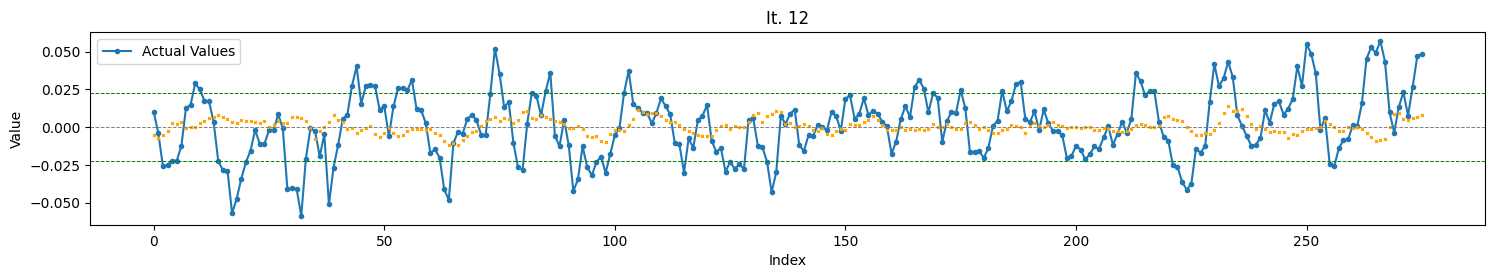

Completed Iteration 12/36

Iteration 13/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_25 (LSTM)              (None, 25)                5100      
                                                                 
 dense_12 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
______________

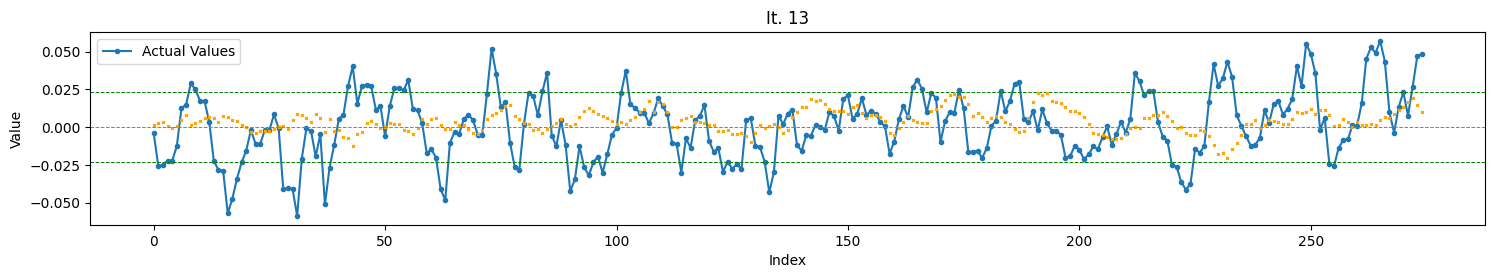

Completed Iteration 13/36

Iteration 14/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_27 (LSTM)              (None, 25)                5100      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
______________

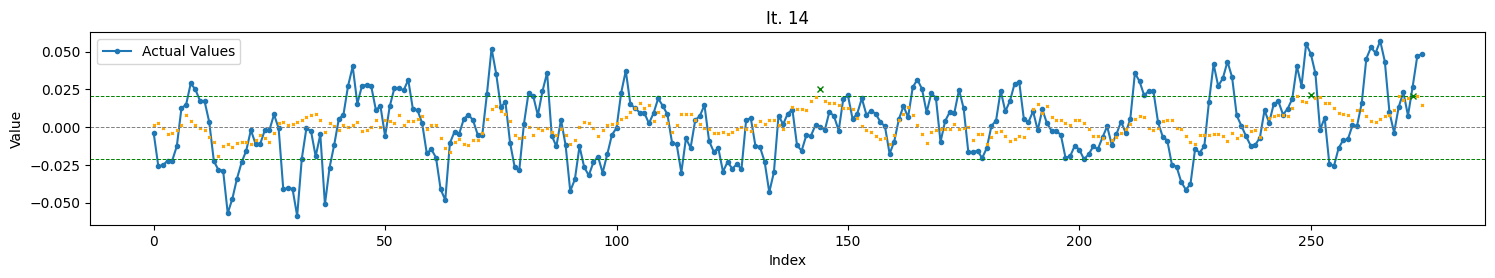

Completed Iteration 14/36

Iteration 15/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_29 (LSTM)              (None, 25)                5100      
                                                                 
 dense_14 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

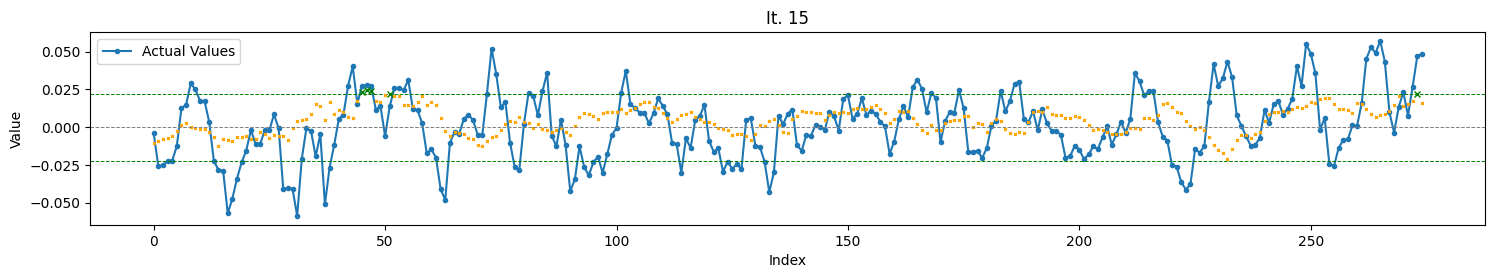

Completed Iteration 15/36

Iteration 16/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_31 (LSTM)              (None, 75)                30300     
                                                                 
 dense_15 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
__________

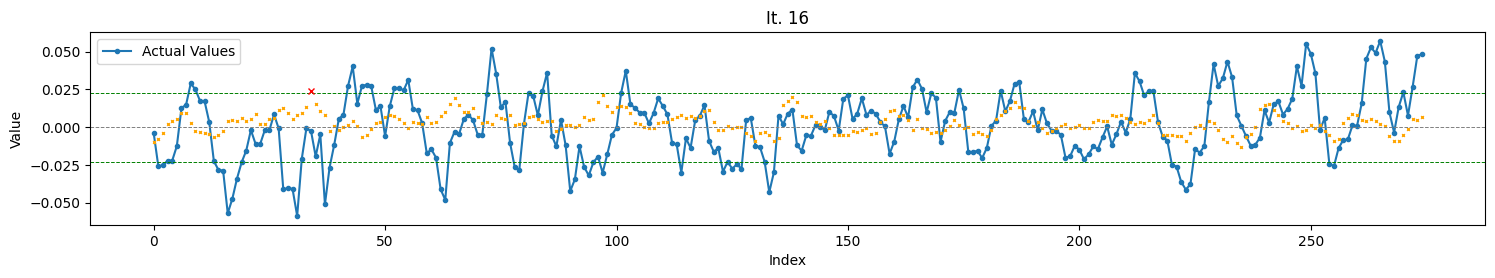

Completed Iteration 16/36

Iteration 17/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_33 (LSTM)              (None, 75)                30300     
                                                                 
 dense_16 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
__________

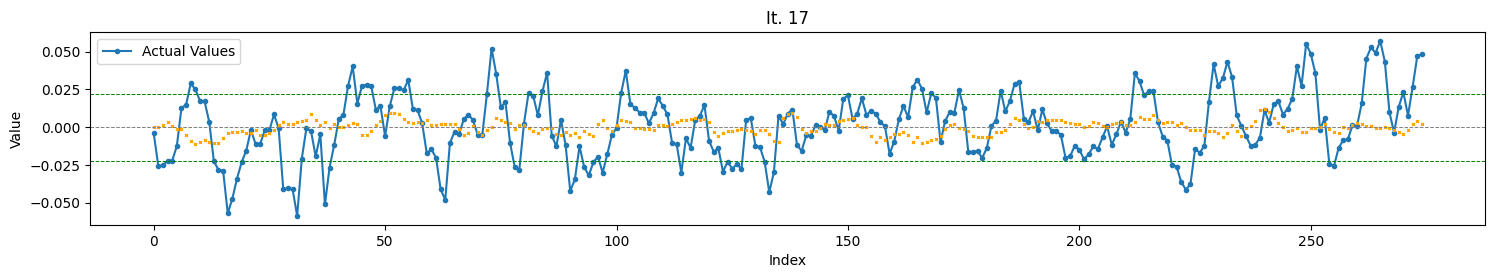

Completed Iteration 17/36

Iteration 18/36
Params: n_steps: 60, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 25)            3600      
                                                                 
 lstm_35 (LSTM)              (None, 75)                30300     
                                                                 
 dense_17 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
___________

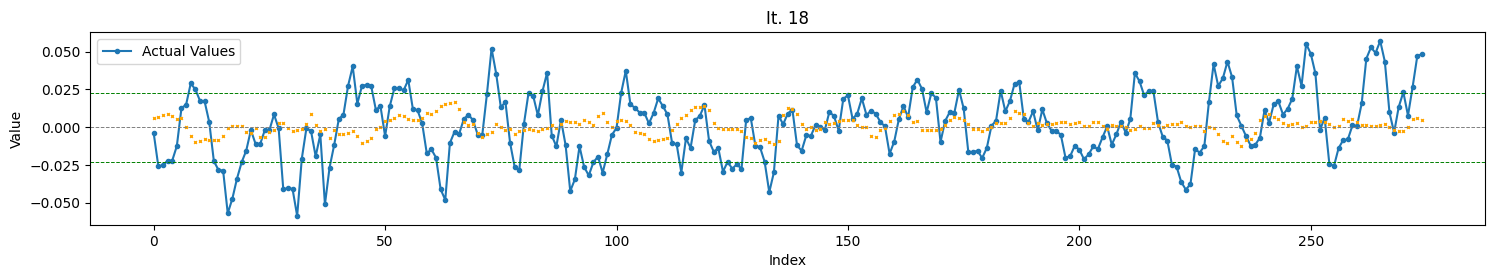

Completed Iteration 18/36

Iteration 19/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_37 (LSTM)              (None, 25)                10100     
                                                                 
 dense_18 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
__________

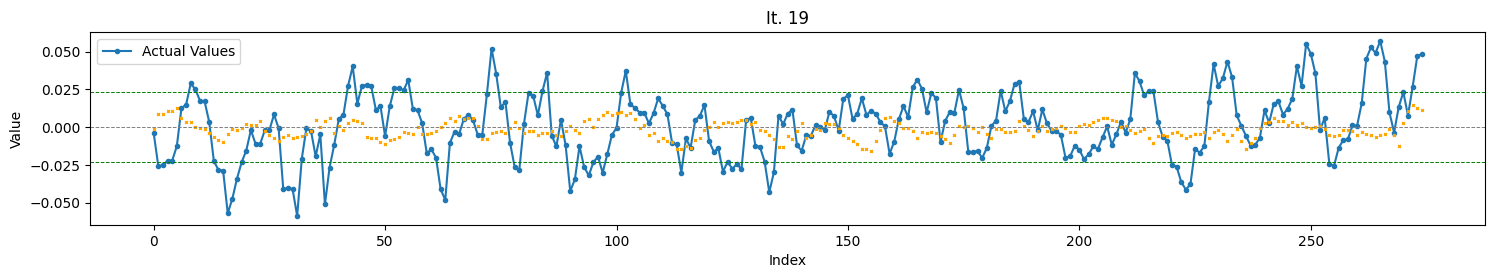

Completed Iteration 19/36

Iteration 20/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_39 (LSTM)              (None, 25)                10100     
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
__________

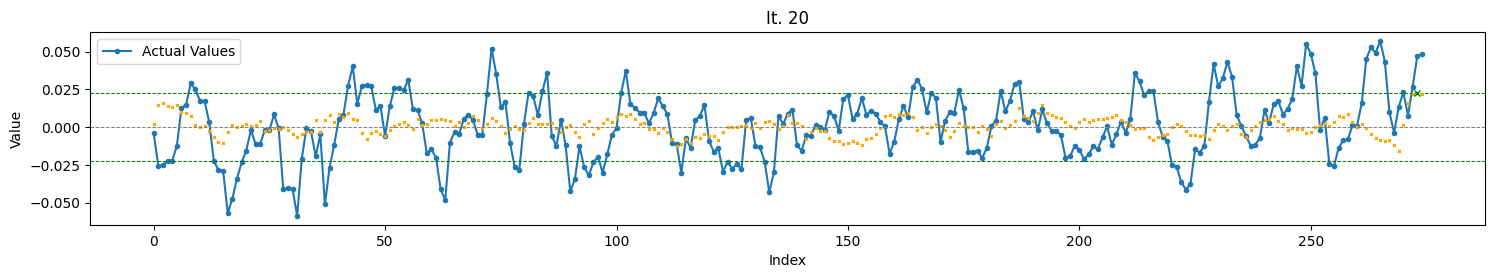

Completed Iteration 20/36

Iteration 21/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_41 (LSTM)              (None, 25)                10100     
                                                                 
 dense_20 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
___________

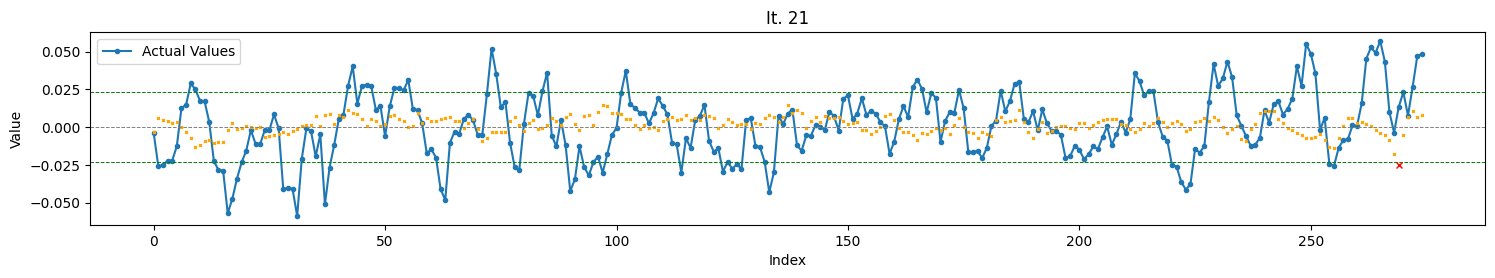

Completed Iteration 21/36

Iteration 22/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_43 (LSTM)              (None, 75)                45300     
                                                                 
 dense_21 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
__________

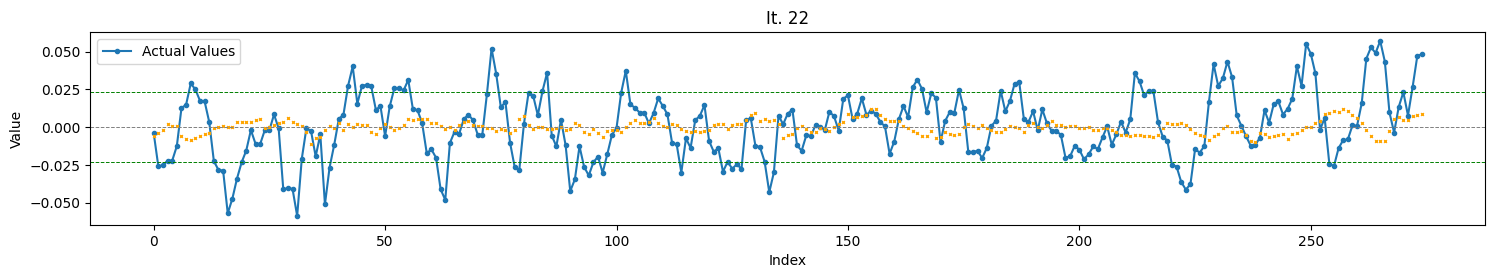

Completed Iteration 22/36

Iteration 23/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_45 (LSTM)              (None, 75)                45300     
                                                                 
 dense_22 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
__________

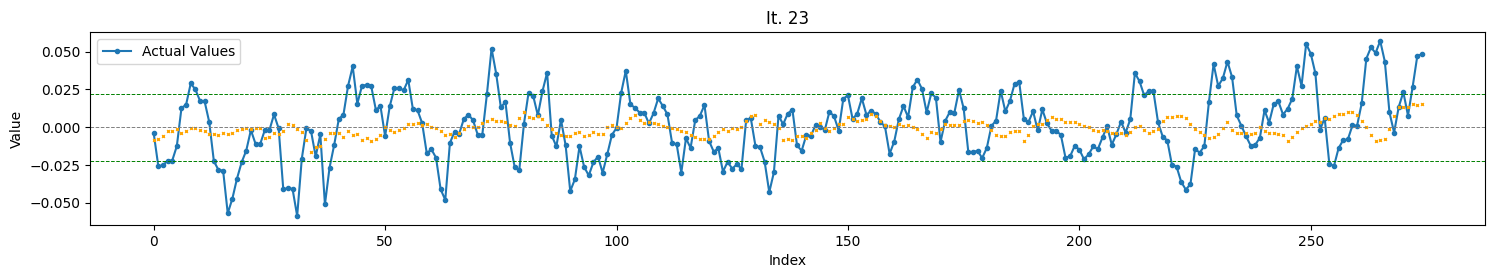

Completed Iteration 23/36

Iteration 24/36
Params: n_steps: 60, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (60, 10)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 60, 75)            25800     
                                                                 
 lstm_47 (LSTM)              (None, 75)                45300     
                                                                 
 dense_23 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
___________

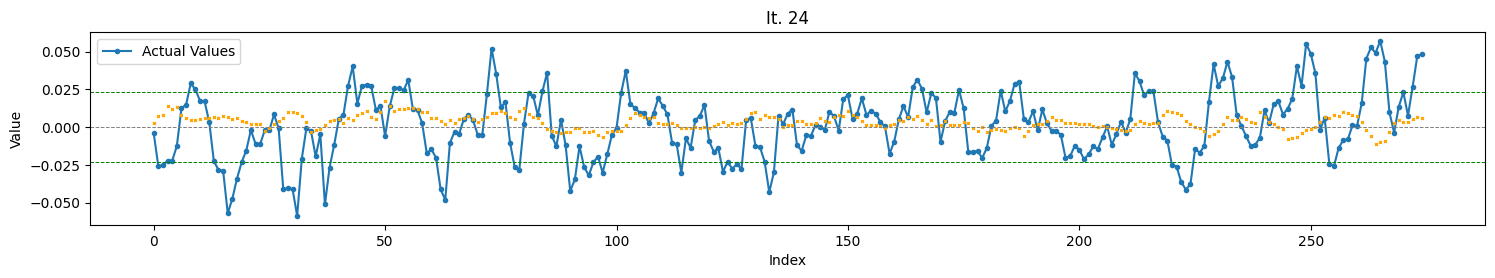

Completed Iteration 24/36

Iteration 25/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_49 (LSTM)              (None, 25)                5100      
                                                                 
 dense_24 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________

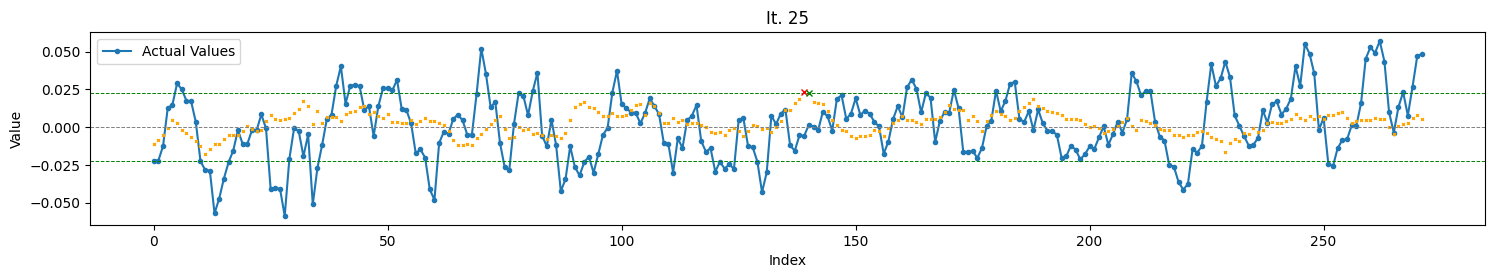

Completed Iteration 25/36

Iteration 26/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_51 (LSTM)              (None, 25)                5100      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
____________

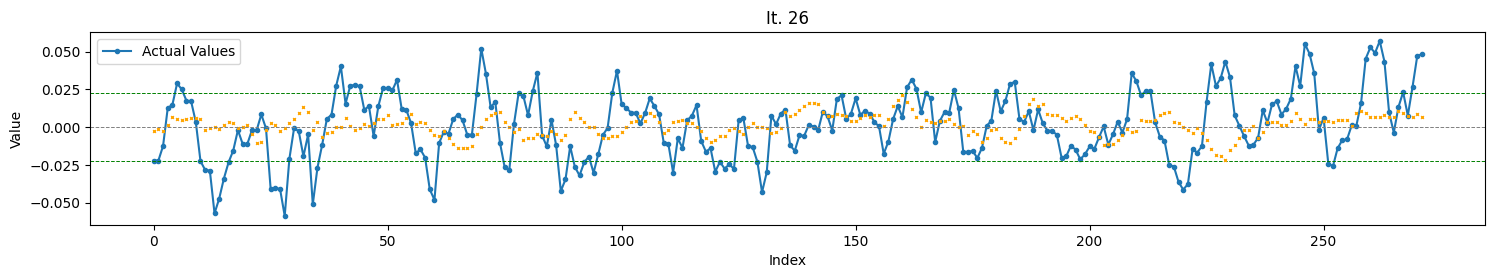

Completed Iteration 26/36

Iteration 27/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_53 (LSTM)              (None, 25)                5100      
                                                                 
 dense_26 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8726 (34.09 KB)
Trainable params: 8726 (34.09 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

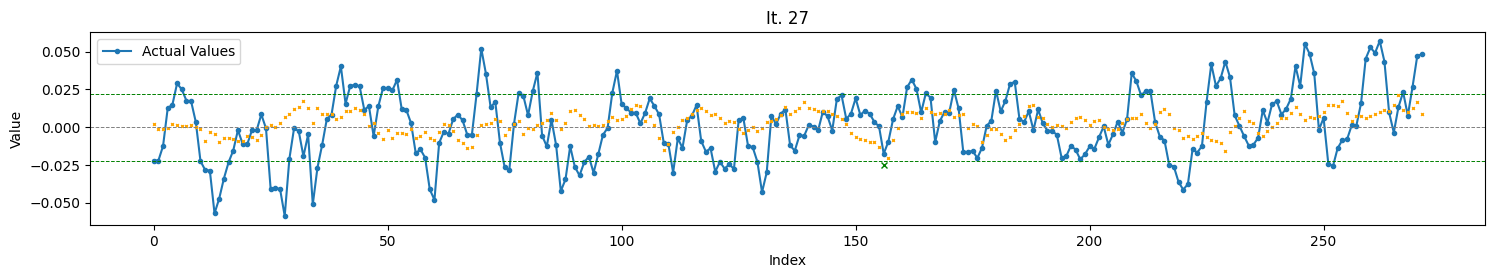

Completed Iteration 27/36

Iteration 28/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_55 (LSTM)              (None, 75)                30300     
                                                                 
 dense_27 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
________

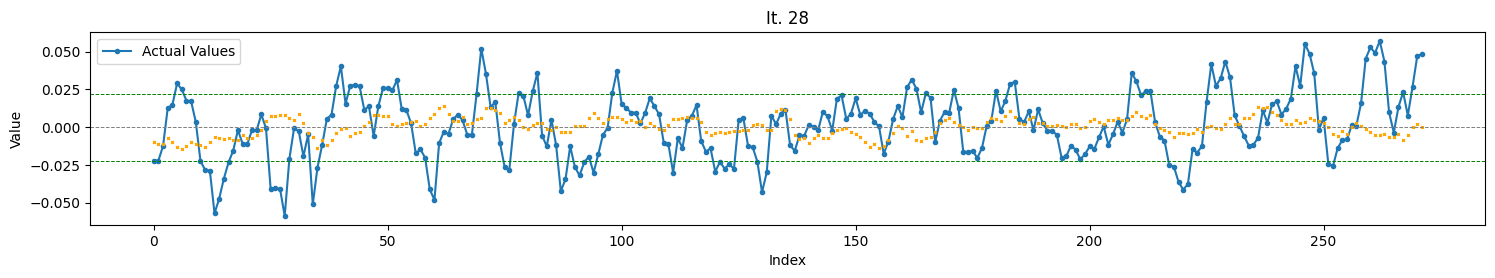

Completed Iteration 28/36

Iteration 29/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_57 (LSTM)              (None, 75)                30300     
                                                                 
 dense_28 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
________

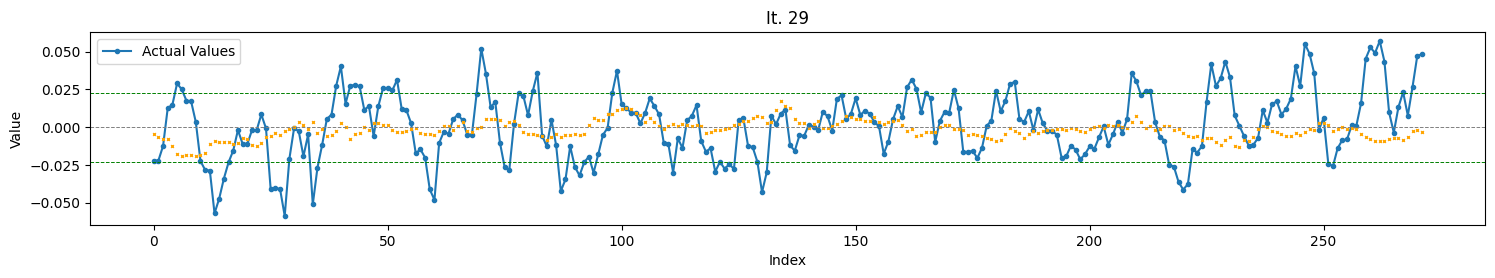

Completed Iteration 29/36

Iteration 30/36
Params: n_steps: 120, lstm_units1: 25, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 120, 25)           3600      
                                                                 
 lstm_59 (LSTM)              (None, 75)                30300     
                                                                 
 dense_29 (Dense)            (None, 1)                 76        
                                                                 
Total params: 33976 (132.72 KB)
Trainable params: 33976 (132.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________

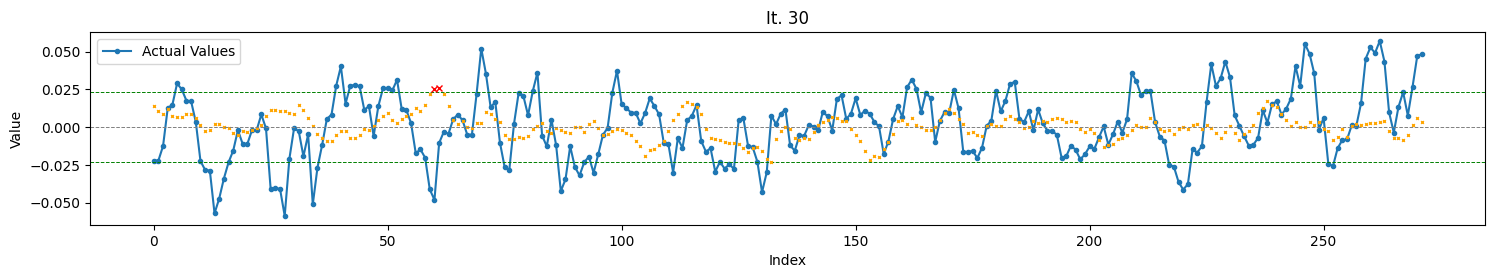

Completed Iteration 30/36

Iteration 31/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_61 (LSTM)              (None, 25)                10100     
                                                                 
 dense_30 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
________

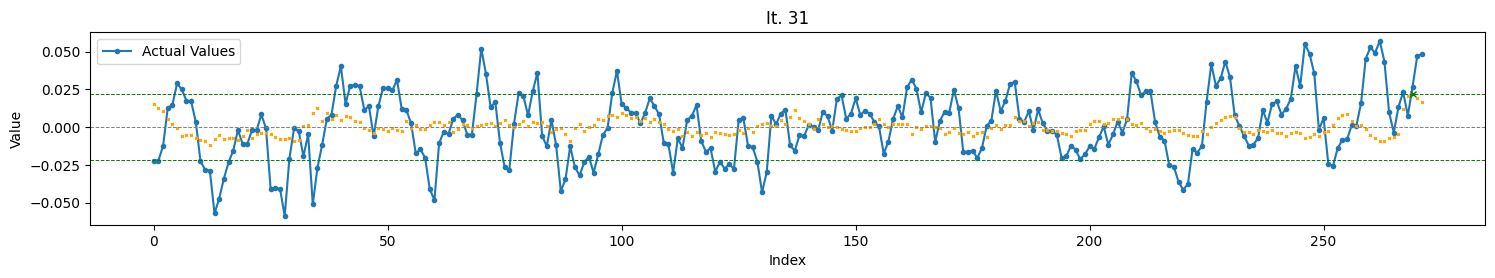

Completed Iteration 31/36

Iteration 32/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_63 (LSTM)              (None, 25)                10100     
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
________

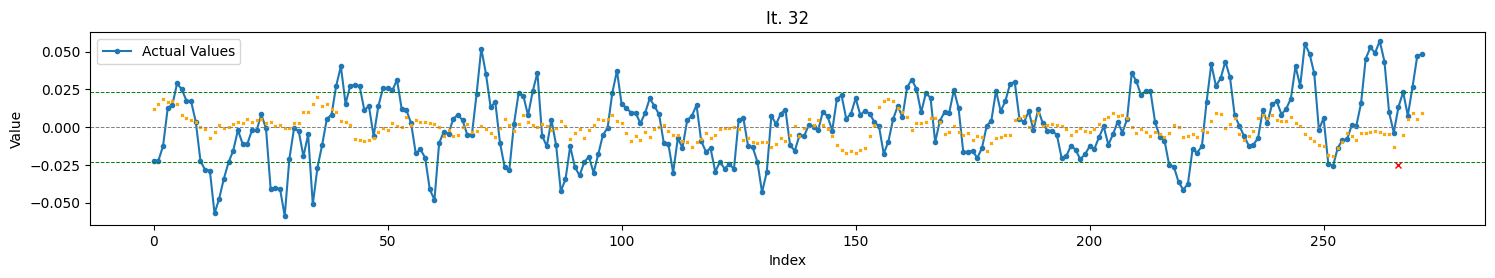

Completed Iteration 32/36

Iteration 33/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 25, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_65 (LSTM)              (None, 25)                10100     
                                                                 
 dense_32 (Dense)            (None, 1)                 26        
                                                                 
Total params: 35926 (140.34 KB)
Trainable params: 35926 (140.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________

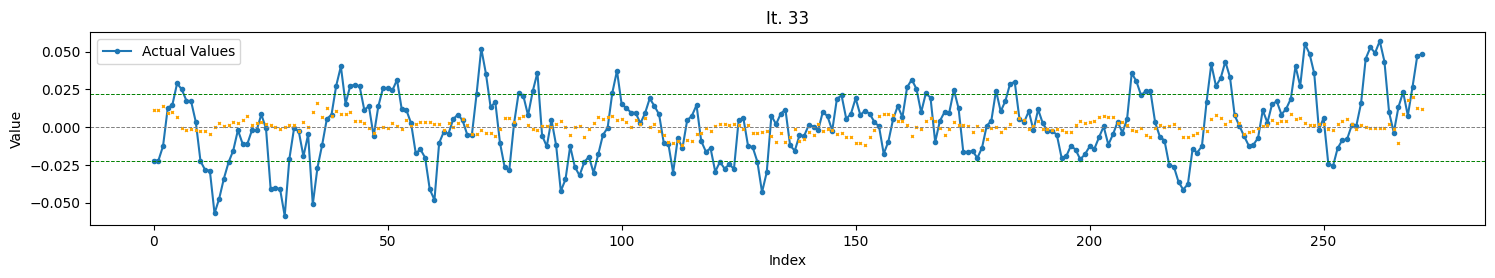

Completed Iteration 33/36

Iteration 34/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 256
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_67 (LSTM)              (None, 75)                45300     
                                                                 
 dense_33 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
________

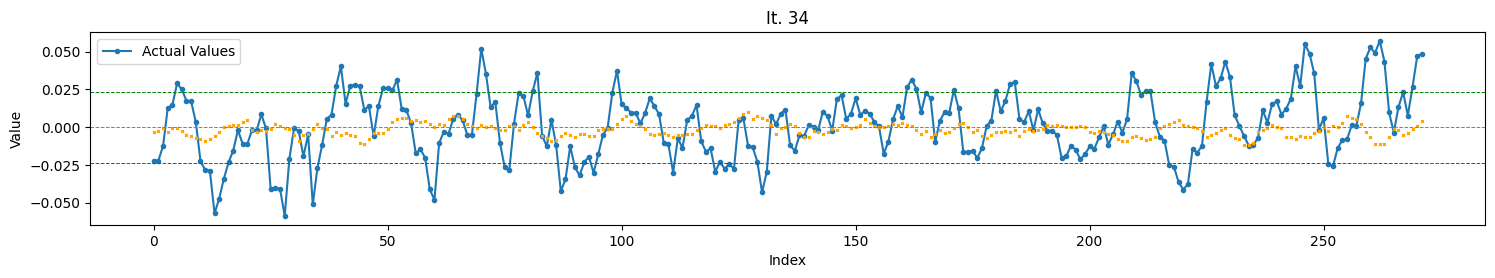

Completed Iteration 34/36

Iteration 35/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 128
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_69 (LSTM)              (None, 75)                45300     
                                                                 
 dense_34 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
________

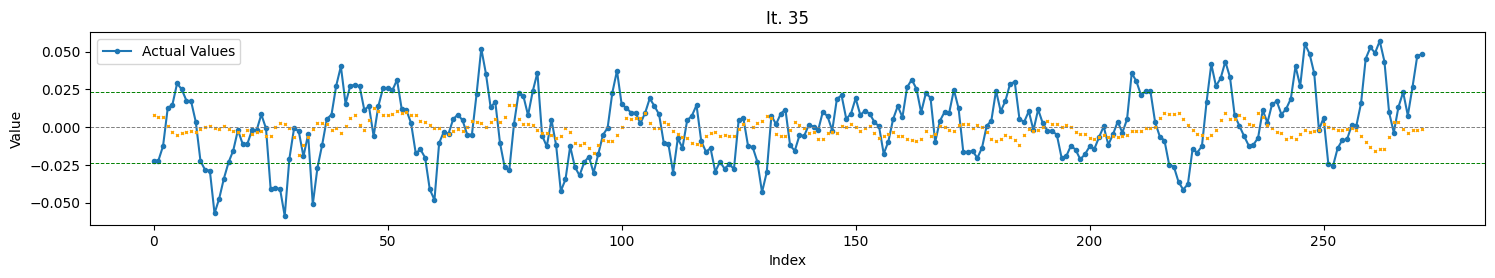

Completed Iteration 35/36

Iteration 36/36
Params: n_steps: 120, lstm_units1: 75, lstm_units2: 75, activation: relu, dropout: 0.15, num_layers: 2
Train : batch> 64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Input shape: (120, 10)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 120, 75)           25800     
                                                                 
 lstm_71 (LSTM)              (None, 75)                45300     
                                                                 
 dense_35 (Dense)            (None, 1)                 76        
                                                                 
Total params: 71176 (278.03 KB)
Trainable params: 71176 (278.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________

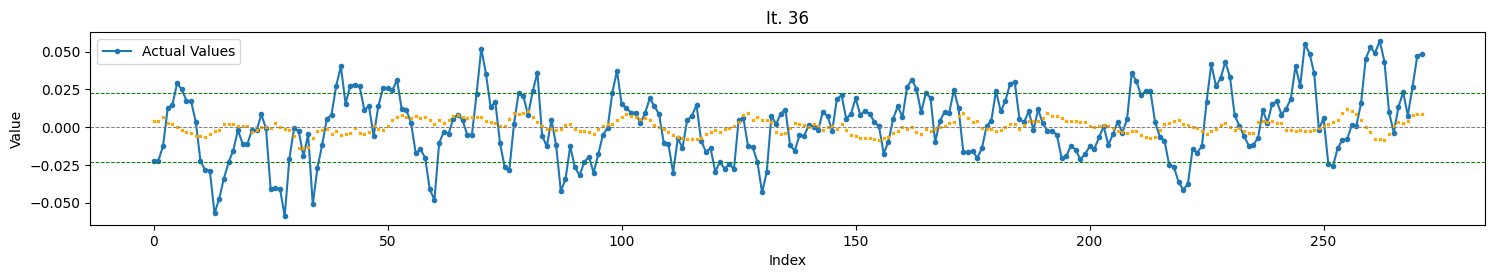

Completed Iteration 36/36


In [ ]:
top_results = run_model_iterations()

In [ ]:
top_results_sort = sorted(top_results, key=lambda x: x['diff'])[:15]

Top 1 
RMSE: 0.020737, STD_DEV: 0.022002, STD_PRD: 0.008214, OBJDIFF: 0.002182, RDIFF: -0.001265
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023672, inv. diff> 0.008564
Trend accuracy       : 57.299
Trend up accuracy    : 60.690
Trend down accuracy  : 53.488


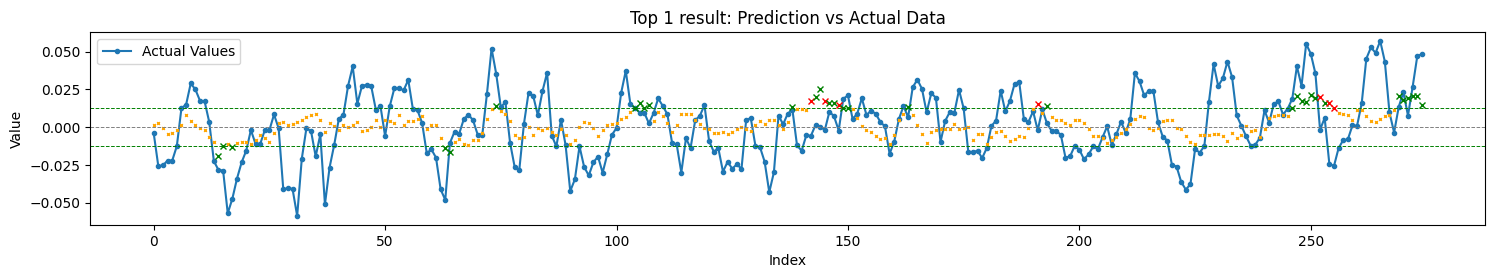

Total TH Pred.: 39
TH Pred. acc. : 82.05


Top 2 
RMSE: 0.021397, STD_DEV: 0.021968, STD_PRD: 0.007595, OBJDIFF: 0.003022, RDIFF: -0.000572
n_steps: 40, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023854, inv. diff> 0.009072
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


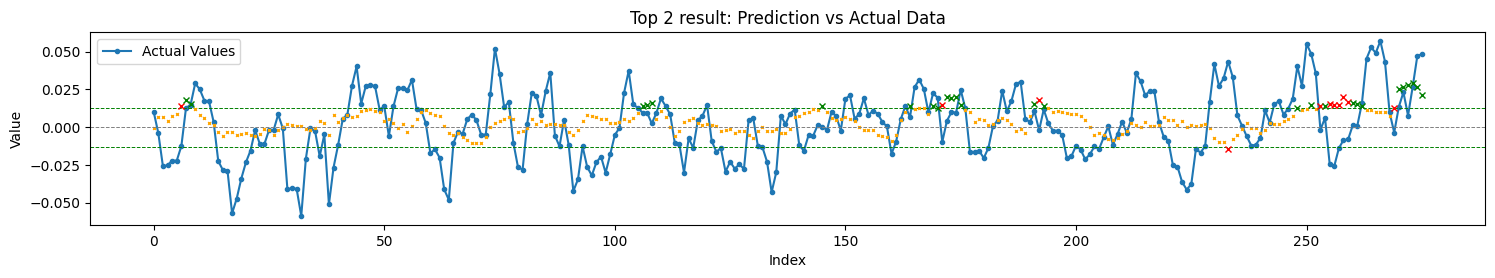

Total TH Pred.: 38
TH Pred. acc. : 71.05


Top 3 
RMSE: 0.021731, STD_DEV: 0.021968, STD_PRD: 0.007308, OBJDIFF: 0.003427, RDIFF: -0.000238
n_steps: 40, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


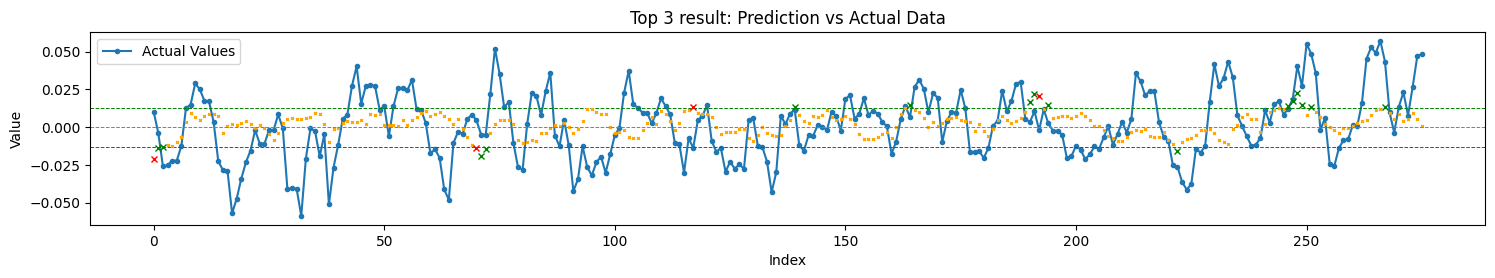

Total TH Pred.: 20
TH Pred. acc. : 80.00


Top 4 
RMSE: 0.021695, STD_DEV: 0.021968, STD_PRD: 0.005467, OBJDIFF: 0.003852, RDIFF: -0.000274
n_steps: 40, lstm_u1: 25, lstm_u2: 75, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022665, inv. diff> 0.008947
Trend accuracy       : 58.909
Trend up accuracy    : 58.904
Trend down accuracy  : 58.915


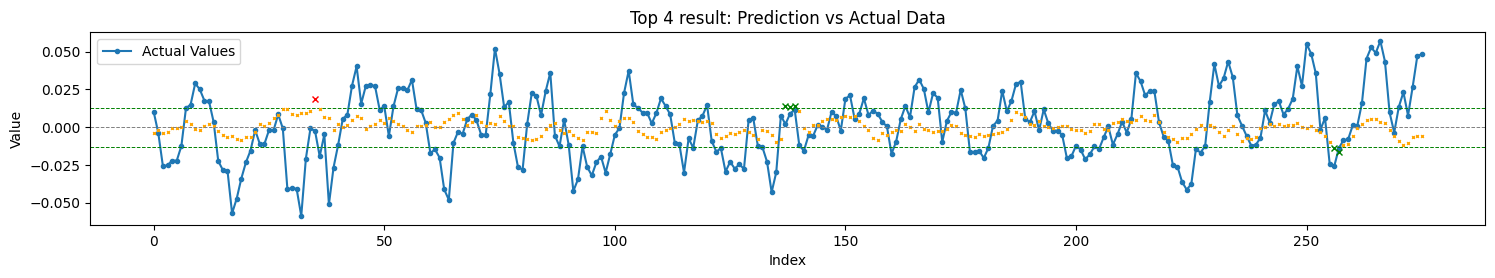

Total TH Pred.: 6
TH Pred. acc. : 83.33


Top 5 
RMSE: 0.021686, STD_DEV: 0.022002, STD_PRD: 0.005280, OBJDIFF: 0.003864, RDIFF: -0.000316
n_steps: 120, lstm_u1: 75, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022673, inv. diff> 0.009032
Trend accuracy       : 57.196
Trend up accuracy    : 54.483
Trend down accuracy  : 60.317


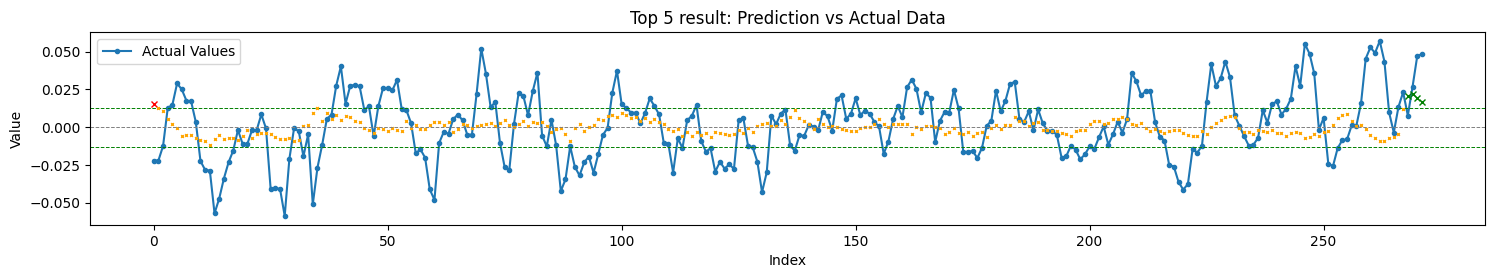

Total TH Pred.: 5
TH Pred. acc. : 80.00


Top 6 
RMSE: 0.022282, STD_DEV: 0.022002, STD_PRD: 0.008649, OBJDIFF: 0.006956, RDIFF: 0.000280
n_steps: 60, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.024322, inv. diff> 0.008996
Trend accuracy       : 57.299
Trend up accuracy    : 71.034
Trend down accuracy  : 41.860


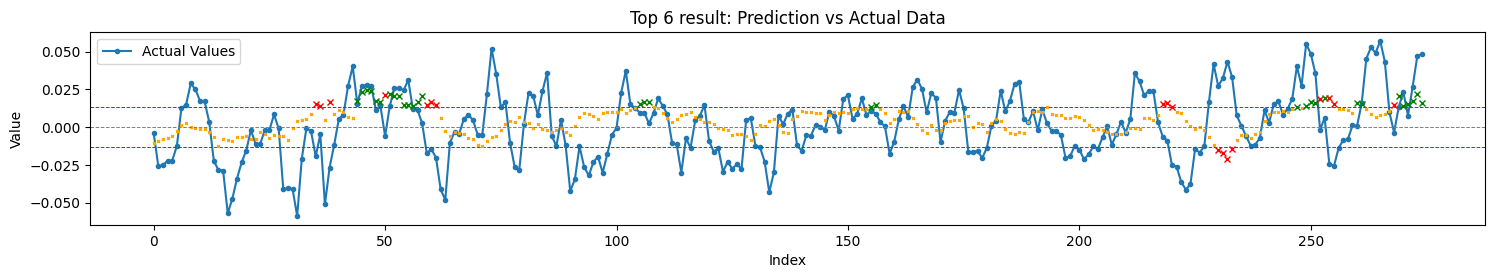

Total TH Pred.: 50
TH Pred. acc. : 64.00


Top 7 
RMSE: 0.022163, STD_DEV: 0.022002, STD_PRD: 0.007531, OBJDIFF: 0.007396, RDIFF: 0.000161
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023598, inv. diff> 0.008832
Trend accuracy       : 53.875
Trend up accuracy    : 67.586
Trend down accuracy  : 38.095


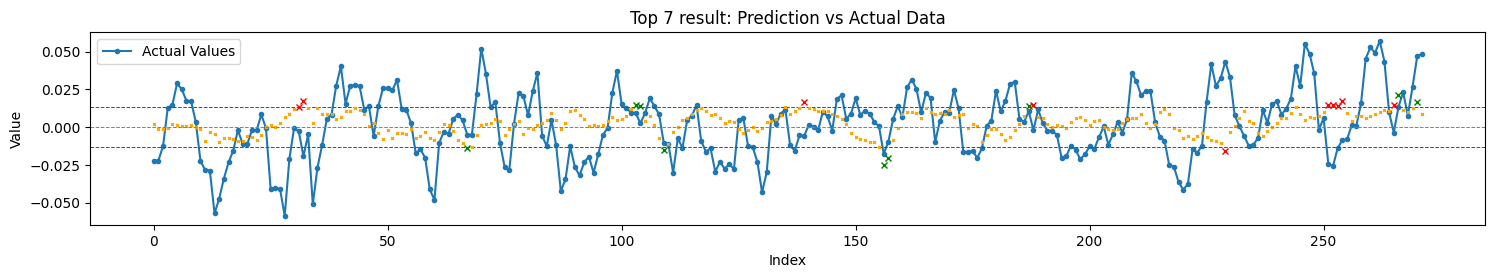

Total TH Pred.: 19
TH Pred. acc. : 47.37


Top 8 
RMSE: 0.022337, STD_DEV: 0.022002, STD_PRD: 0.007277, OBJDIFF: 0.007698, RDIFF: 0.000336
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023537, inv. diff> 0.008898
Trend accuracy       : 58.672
Trend up accuracy    : 71.724
Trend down accuracy  : 43.651


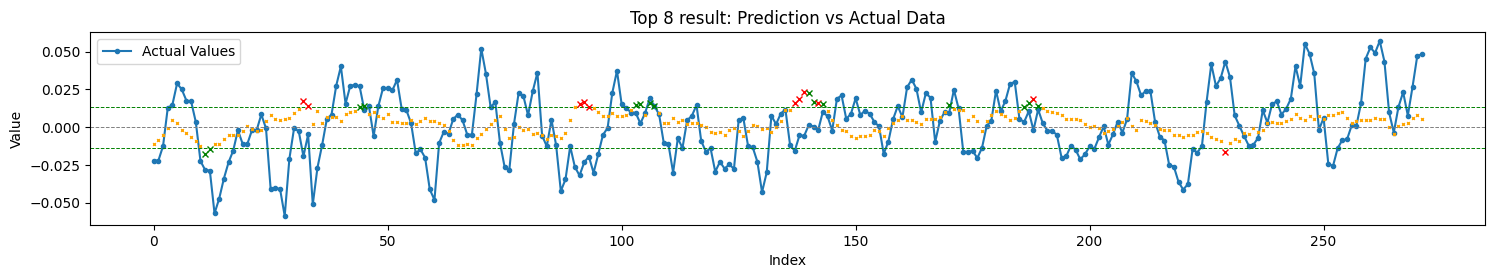

Total TH Pred.: 26
TH Pred. acc. : 57.69


Top 9 
RMSE: 0.021969, STD_DEV: 0.021968, STD_PRD: 0.006443, OBJDIFF: 0.007763, RDIFF: 0.000000
n_steps: 40, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023267, inv. diff> 0.009061
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


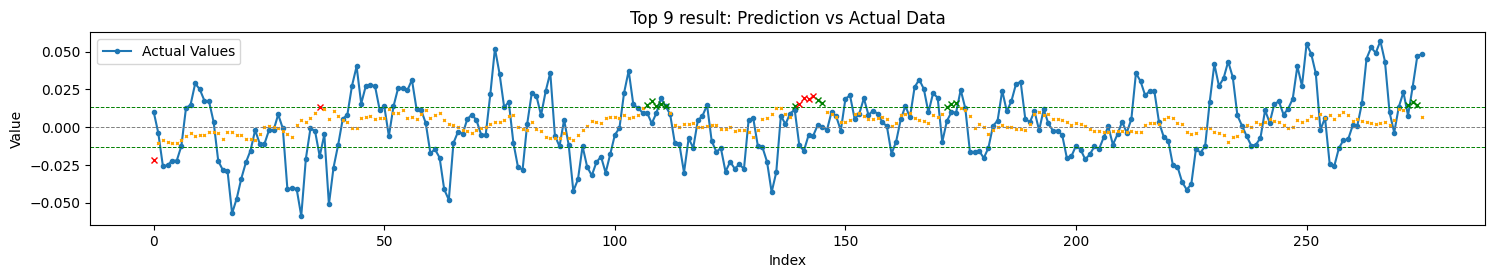

Total TH Pred.: 20
TH Pred. acc. : 70.00


Top 10 
RMSE: 0.022521, STD_DEV: 0.022002, STD_PRD: 0.007020, OBJDIFF: 0.008010, RDIFF: 0.000519
n_steps: 120, lstm_u1: 25, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023265, inv. diff> 0.008754
Trend accuracy       : 57.565
Trend up accuracy    : 66.897
Trend down accuracy  : 46.825


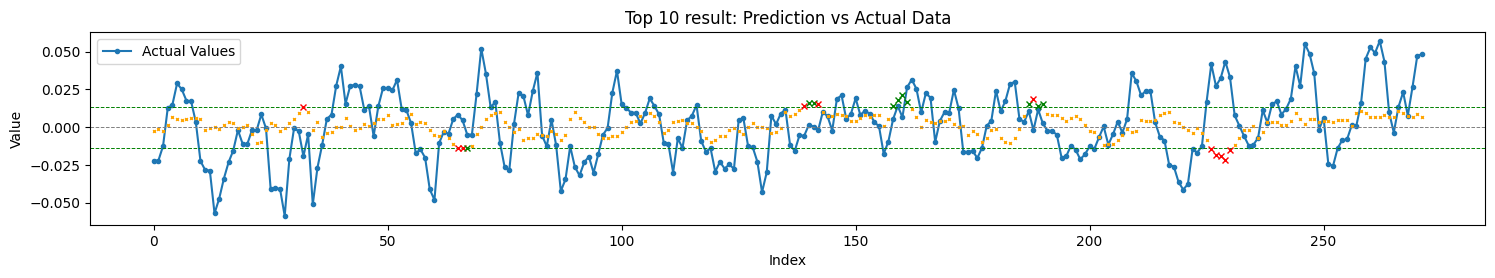

Total TH Pred.: 21
TH Pred. acc. : 47.62


Top 11 
RMSE: 0.022173, STD_DEV: 0.022002, STD_PRD: 0.006127, OBJDIFF: 0.008108, RDIFF: 0.000171
n_steps: 120, lstm_u1: 25, lstm_u2: 75, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022905, inv. diff> 0.008840
Trend accuracy       : 55.720
Trend up accuracy    : 60.690
Trend down accuracy  : 50.000


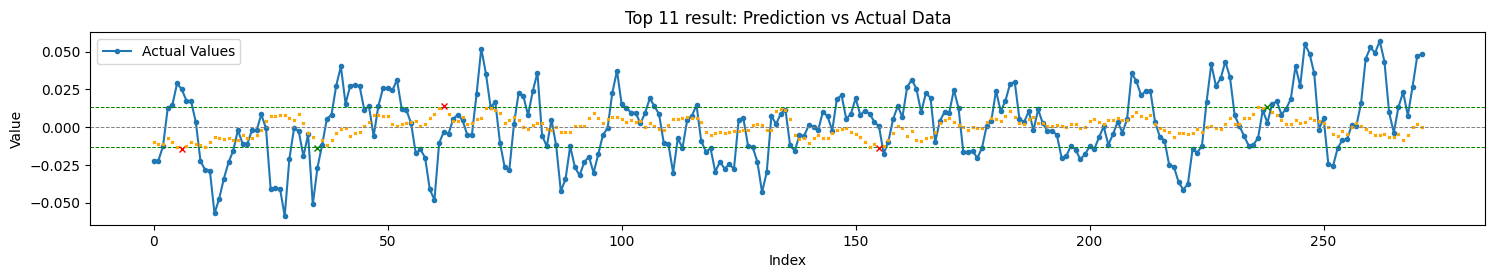

Total TH Pred.: 5
TH Pred. acc. : 40.00


Top 12 
RMSE: 0.023171, STD_DEV: 0.022002, STD_PRD: 0.007974, OBJDIFF: 0.008183, RDIFF: 0.001169
n_steps: 120, lstm_u1: 25, lstm_u2: 75, activation: relu, dropout: 0.15, batch_size: 64, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023449, inv. diff> 0.008461
Trend accuracy       : 56.089
Trend up accuracy    : 56.552
Trend down accuracy  : 55.556


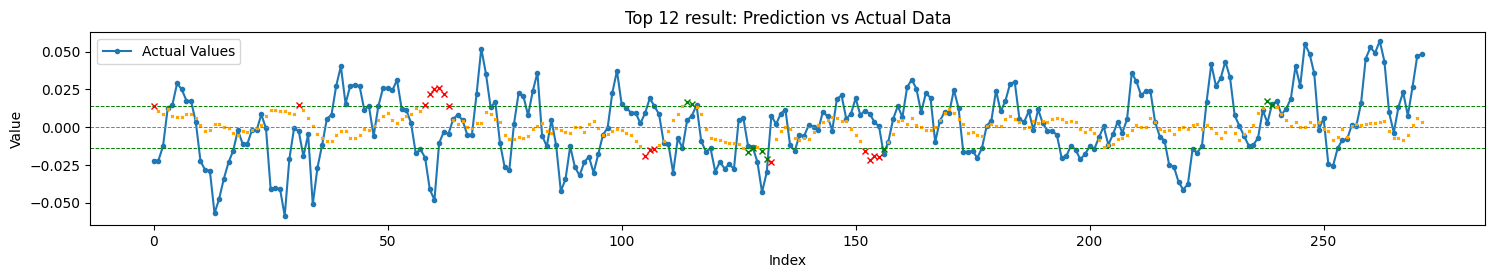

Total TH Pred.: 25
TH Pred. acc. : 36.00


Top 13 
RMSE: 0.022280, STD_DEV: 0.021968, STD_PRD: 0.005861, OBJDIFF: 0.008365, RDIFF: 0.000312
n_steps: 40, lstm_u1: 25, lstm_u2: 75, activation: relu, dropout: 0.15, batch_size: 256, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023069, inv. diff> 0.009154
Trend accuracy       : 52.727
Trend up accuracy    : 69.863
Trend down accuracy  : 33.333


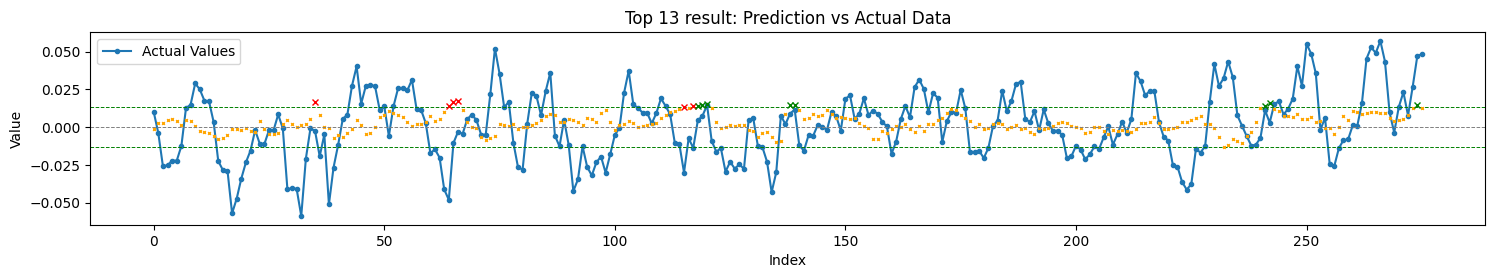

Total TH Pred.: 14
TH Pred. acc. : 57.14


Top 14 
RMSE: 0.022578, STD_DEV: 0.021968, STD_PRD: 0.006368, OBJDIFF: 0.008410, RDIFF: 0.000609
n_steps: 40, lstm_u1: 75, lstm_u2: 75, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023256, inv. diff> 0.009087
Trend accuracy       : 54.182
Trend up accuracy    : 69.863
Trend down accuracy  : 36.434


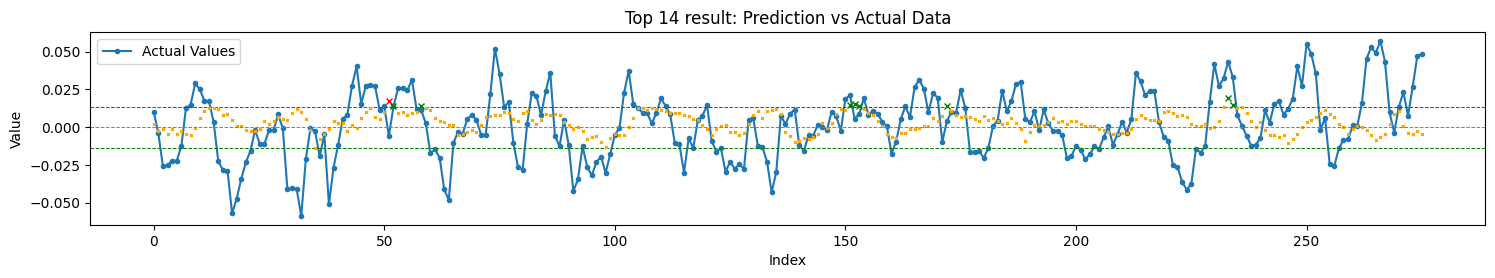

Total TH Pred.: 9
TH Pred. acc. : 88.89


Top 15 
RMSE: 0.023133, STD_DEV: 0.022002, STD_PRD: 0.007339, OBJDIFF: 0.008463, RDIFF: 0.001131
n_steps: 120, lstm_u1: 75, lstm_u2: 25, activation: relu, dropout: 0.15, batch_size: 128, epochs: 300
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023208, inv. diff> 0.008538
Trend accuracy       : 51.292
Trend up accuracy    : 47.586
Trend down accuracy  : 55.556


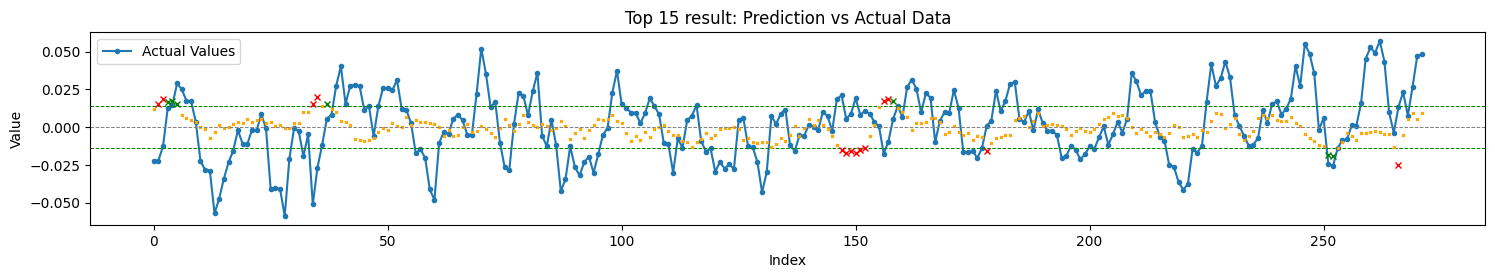

Total TH Pred.: 21
TH Pred. acc. : 33.33




In [ ]:
for i,result in enumerate(top_results_sort,1):

    # if result['rmse']-result['std_dev'] >= 0:
    #     continue

    print(f"Top {i} ")

    # if (result['rmse']<result['std_dev']):
    #     result['diff'] = result['rmse']-result['std_dev'] + abs(np.std(result['predictions']) - result['std_dev'])/4.0
    # else:
    #     result['diff'] = (result['rmse']- result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0

    print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(result['rmse'], result['std_dev'], np.std(result['predictions']), result['diff'],result['rmse']-result['std_dev']))
    print("n_steps: {}, lstm_u1: {}, lstm_u2: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units1'], result['lstm_units2'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    print("Feature list: ", result['feature_list'])

    # var_tot     = set(variable_options)
    # fea_list    = set(result['feature_list'])
    # print("Discarded var: {}".format(var_tot - fea_list))

    result['inv_rmse'] = inv_rmse = rmse(result['true_values'], result['predictions']*-1)
    inv_diff = (inv_rmse - result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
    print("Inv. rmse> {:.6f}, inv. diff> {:.6f}".format(inv_rmse, inv_diff))

    # calculate trend prediction percentage

    trend_up_true   = 0
    trend_down_true = 0
    trend_up_pred   = 0
    trend_down_pred = 0

    for j in range(len(result['true_values'])-1):
        if result['true_values'][j] > 0.0:
            trend_up_pred += 1
            if result['predictions'][j] > 0.0:
                trend_up_true += 1
        if result['true_values'][j] < 0.0:
            trend_down_pred += 1
            if result['predictions'][j] < 0.0:
                trend_down_true += 1

    trend_true      = trend_up_true + trend_down_true
    trend_pred      = trend_up_pred + trend_down_pred
    trend_accuracy  = trend_true/trend_pred
    print("Trend accuracy       : {:.3f}".format(trend_accuracy*100))
    print("Trend up accuracy    : {:.3f}".format(trend_up_true*100/trend_up_pred))
    print("Trend down accuracy  : {:.3f}".format(trend_down_true*100/trend_down_pred))

    mult = .6
    tot_pred, prof, loss = plot_predictions(result['true_values'], result['predictions'],-1, title=f"Top {i} result: Prediction vs Actual Data",rmse=result['rmse']*mult)
    print("Total TH Pred.: {}".format(tot_pred))
    if tot_pred != 0:
        print("TH Pred. acc. : {:.2f}".format(prof*100.0/tot_pred))
    print('\n')


In [ ]:
# export the best result predictions and true values to a csv file
best_result = top_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('./output/lstm_best_result.csv', index=False)